<a href="https://colab.research.google.com/github/thomascong121/SocialDistance/blob/master/model_camera_colibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%%capture
!pip install gluoncv
!pip install mxnet-cu101

In [0]:
import gluoncv
from gluoncv import model_zoo, data, utils
from matplotlib import pyplot as plt
import numpy as np
from collections import defaultdict

from mxnet import nd
import mxnet as mx
from skimage import io

import cv2
import os
from copy import deepcopy
from tqdm import tqdm

In [0]:
!ls '/content/drive/My Drive/social distance/0.png'

'/content/drive/My Drive/social distance/0.png'


In [0]:
!nvidia-smi

Wed Apr 29 01:15:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [0]:
img_path = '/content/drive/My Drive/social distance/0.png'
img = io.imread(img_path)

In [0]:
video_path = '/content/drive/My Drive/social distance/TownCentreXVID.avi'

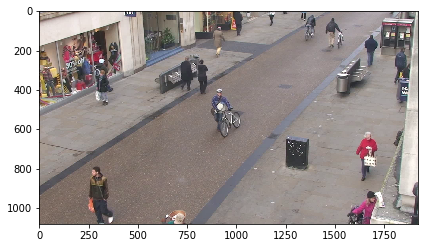

In [0]:
io.imshow(img)
io.show()

In [0]:
class Bird_eye_view_Transformer:
    def __init__(self, keypoints, keypoints_birds_eye_view, actual_length, actual_width):
        '''
        keypoints input order 
        0   1

        3   2
        '''
        self.keypoint = np.float32(keypoints)
        self.keypoints_birds_eye_view = np.float32(keypoints_birds_eye_view)
        self.M = cv2.getPerspectiveTransform(self.keypoint, self.keypoints_birds_eye_view)
        self.length_ratio = actual_width/(keypoints_birds_eye_view[3][1] - keypoints_birds_eye_view[0][1])
        self.width_ratio = actual_length/(keypoints_birds_eye_view[1][0] - keypoints_birds_eye_view[0][0])
        print(self.length_ratio, self.width_ratio)

    def imshow(self, img):
        dst_img = cv2.warpPerspective(img, self.M, (img.shape[1], img.shape[0]))
        plt.imshow(dst_img)
        plt.show()

    def __call__(self, points):
        h = points.shape[0]
        points = np.concatenate([points, np.ones((h, 1))], axis = 1)
        temp = self.M.dot(points.T)
        return (temp[:2]/temp[2]).T
    
    def distance(self, p0, p1):
        return ((p0[0] - p1[0])*self.width_ratio)**2 \
        + ((p0[1] - p1[1])*self.length_ratio)**2 



In [0]:
keypoints = [(1175,  189), (1574,  235), (976,  831), (364,  694)]
keypoints_birds_eye_view = [(700,  400), (1200,  400), (1200,  900), (700,  900)]
actual_length = 10
actual_width = 5

In [0]:
transformer = Bird_eye_view_Transformer(keypoints, keypoints_birds_eye_view, actual_length, actual_width)

0.01 0.02


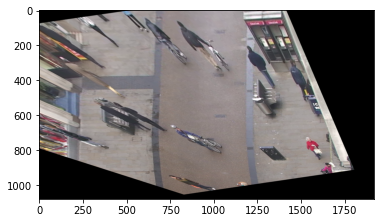

In [0]:
transformer.imshow(img)

In [0]:
'''
step0 install gluoncv
pip install --upgrade mxnet gluoncv
'''
class Model_Zoo:
    def __init__(self,selected_model, transformer, device):
        self.device = device
        self.transformer = transformer
        self.net = model_zoo.get_model(selected_model, pretrained=True, ctx = self.device)

    def __call__(self,image,display=False):
        '''get bbox for input image'''
        image = nd.array(image)
        x, orig_img = data.transforms.presets.yolo.transform_test(image)
        self.shape = orig_img.shape[:2]
        self.benchmark = max(orig_img.shape[:2])
        x = x.copyto(self.device)
        box_ids, scores, bboxes = self.net(x)
        bboxes = bboxes * (image.shape[0]/orig_img.shape[0])
        person_index = []

        #check person class
        for i in range(box_ids.shape[1]):
            if box_ids[0][i][0] == 14 and scores[0][i][0] > 0.7:
                person_index.append(i)
        #select bbox of person
        #p1:bbox id of person
        #p2:confidence score
        #p3:bbox location
        # print('======{0} bbox of persons are detected===='.format(len(person_index)))
        p1,p2,p3 = box_ids[0][[person_index],:],scores[0][[person_index],:],bboxes[0][[person_index],:]
        #calaulate bbox coordinate
        bbox_center = self.bbox_center(p3)
        #img with bbox 

        img_with_bbox = utils.viz.cv_plot_bbox(image.astype('uint8'), p3[0], p2[0], p1[0], colors={14: (0,255,0)},class_names = self.net.classes, linewidth=1)
        result_img = self.bbox_distance(bbox_center,img_with_bbox)
        if display:
          plt.imshow(result_img)
          plt.show()
        return result_img, p1, p2, p3, bbox_center

    def show(self, img, p1, p2, p3, bbox_center, resize = None):
        if resize is not None:
            img = mx.image.imresize(nd.array(img).astype('uint8'), self.shape[1], self.shape[0])
        else:
            img = nd.array(img).astype('uint8')
        img_with_bbox = utils.viz.cv_plot_bbox(img, p3[0], p2[0], p1[0], colors={14: (0,255,0)},class_names = self.net.classes, linewidth=1)
        return self.bbox_distance(bbox_center,img_with_bbox)

    def bbox_center(self,bbox_location):
        '''calculate center coordinate for each bbox'''
        rst = None
        for loc in range(bbox_location[0].shape[0]):
            (xmin, ymin, xmax, ymax) = bbox_location[0][loc].copyto(mx.cpu())
            center_x = (xmin+xmax)/2
            center_y = ymax
            if rst is not None:
                rst = nd.concatenate([rst, nd.stack(center_x, center_y, axis = 1)])
            else:
                rst = nd.stack(center_x, center_y, axis = 1)

        return rst.asnumpy()

    def bbox_distance(self,bbox_coord,img, max_detect = 4, safe=2):
        '''
        calculate distance between each bbox, 
        if distance < safe, draw a red line
        '''
        #draw the center
        safe = safe**2
        max_detect = max_detect**2
        for coor in range(len(bbox_coord)):
            cv2.circle(img,(int(bbox_coord[coor][0]),int(bbox_coord[coor][1])),5,(0, 0, 255),-1)

        bird_eye_view = self.transformer(deepcopy(bbox_coord))
        # print(bird_eye_view)
        # self.transformer.imshow(img)

        for i in range(0, len(bbox_coord)):
            for j in range(i+1, len(bbox_coord)):
                dist = self.transformer.distance(bird_eye_view[i], bird_eye_view [j])
                # print(bird_eye_view[i], bird_eye_view [j],dist)
                if dist < safe:
                    cv2.line(img,(bbox_coord[i][0],bbox_coord[i][1]),(bbox_coord[j][0],bbox_coord[j][1]),(255, 0, 0), 2)
                elif dist < max_detect:
                    cv2.line(img,(bbox_coord[i][0],bbox_coord[i][1]),(bbox_coord[j][0],bbox_coord[j][1]),(0, 255, 0), 2)
        return img


In [0]:
pretrained_models = 'yolo3_darknet53_voc'
detect_model = Model_Zoo(pretrained_models, transformer, mx.gpu())

223070KB [00:08, 26788.77KB/s]                            


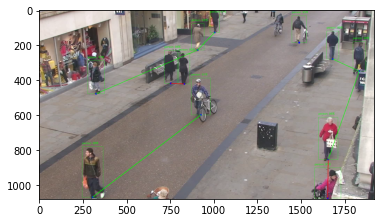

CPU times: user 969 ms, sys: 1.75 s, total: 2.72 s
Wall time: 11.1 s


In [0]:
%%time
rst = detect_model(img,display=True)

In [0]:
rst

(array([[[121, 113, 121],
         [120, 112, 120],
         [119, 111, 119],
         ...,
         [219, 222, 212],
         [215, 218, 208],
         [214, 217, 207]],
 
        [[120, 112, 120],
         [121, 113, 121],
         [123, 115, 123],
         ...,
         [218, 221, 211],
         [215, 218, 208],
         [213, 216, 206]],
 
        [[134, 128, 135],
         [136, 130, 137],
         [140, 134, 141],
         ...,
         [216, 219, 209],
         [213, 216, 206],
         [212, 215, 205]],
 
        ...,
 
        [[120, 105,  96],
         [122, 107,  98],
         [123, 108,  99],
         ...,
         [ 51,  65,  58],
         [ 76,  90,  83],
         [ 95, 109, 102]],
 
        [[122, 107,  98],
         [123, 108,  99],
         [125, 110, 101],
         ...,
         [ 51,  65,  58],
         [ 77,  91,  84],
         [ 98, 112, 105]],
 
        [[123, 108,  99],
         [125, 110, 101],
         [127, 112, 103],
         ...,
         [ 51,  65,  58],
  

In [0]:
class Detector:
  def __init__(self, model, save_path = './detections', batch_size = 60, interval = None):
    self.detector = model
    self.save_path = save_path
    self.interval = interval
    self.batch_size = batch_size

  def __call__(self, filename):
    v_cap = cv2.VideoCapture(filename)
    v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_size = (v_cap.get(cv2.CAP_PROP_FRAME_WIDTH), v_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    fps = v_cap.get(cv2.CAP_PROP_FPS)
    if not os.path.exists(self.save_path):
        os.mkdir(self.save_path)
    print(f'{self.save_path}/{filename.split("/")[-1]}')
    out = cv2.VideoWriter(f'{self.save_path}/{filename.split("/")[-1]}', fourcc, fps,\
                          (int(frame_size[0]), int(frame_size[1])))   
    
    if self.interval is None:
      sample = np.arange(0, v_len)
    else:
      sample = np.arange(0, v_len, self.interval)
    frame = p1 = p2 = p3 = bbox_center =None
    for i in tqdm(range(v_len)):
      success = v_cap.grab()
      
      success, frame = v_cap.retrieve()
      if not success:
        continue
      frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

      if i in sample:
        frame, p1, p2, p3, bbox_center = self.detector(frame)
      else:
        frame = self.detector.show(frame, p1, p2, p3, bbox_center)
      # plt.imshow(frame)
      # plt.show()
      frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
      out.write(frame)

    v_cap.release()
    return out

    


In [0]:
detector = Detector(detect_model, interval = 10)

In [0]:
%%time
detector(video_path)

  0%|          | 0/7500 [00:00<?, ?it/s]

./detections/TownCentreXVID.avi


100%|██████████| 7500/7500 [07:27<00:00, 16.75it/s]

CPU times: user 8min 24s, sys: 35.6 s, total: 9min
Wall time: 7min 31s


<VideoWriter 0x7f3885d91230>

In [0]:
!ls ./detections

TownCentreXVID.avi
